#Airbnb price prediction
This projects tends to provide an inclusive broad of Airbnb prices in Riyadh, Saudi Arabia; by analyzing Airbnb to provide several insights from assessing the profitability of investing in them to enhancing hosbitility experience.

>[Airbnb price prediction](#scrollTo=it2KtabWXGA-)

>[Importing dependencies](#scrollTo=iOSd2A4YZmQw)

>[Loading Dataset](#scrollTo=4M8U_6GWaxET)

>[Functions](#scrollTo=xmZ1e949b1pn)

>[Quick look on the data ( Statistics )](#scrollTo=nJrcwI2icyvT)

>[Data Cleaning And Feature Engineering](#scrollTo=9tF3nF9Jezb0)

>>>[Data Imputation](#scrollTo=W5Ds-MySnEVK)

>[EDA](#scrollTo=cT4KhC4on1Os)

>[Clustering](#scrollTo=IyT4YGO0w4j8)

>[Target variable relations](#scrollTo=_d2ind8syWU5)

>[Data distribution](#scrollTo=dKJC0YYgzIU-)

>[Data Prepration](#scrollTo=jQFLhDT1XBhL)

>[Model training and results](#scrollTo=O2v6b6JWXPfd)



#Importing dependencies

In [ ]:
import pandas as pd
import numpy as np
import json
import ast
import plotly.express as px
import plotly.graph_objects as go
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import folium
from scipy.spatial import ConvexHull
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score  , root_mean_squared_error , median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sktime.performance_metrics.forecasting import MedianSquaredError
import pickle

#Loading Dataset

**[Dataset source](https://www.kaggle.com/datasets/mohammedalsubaie/riyadh-airbnb)**

In [ ]:
#Adjust displays of any dataframe to show all data within
pd.set_option('display.max_columns' , None)
pd.set_option('display.max_rows' , None)
pd.set_option('display.max_colwidth' , None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
df = pd.read_excel('airbnb_updated.xlsx')

#Functions

In [ ]:
sns.set_theme(palette = "mako")

In [ ]:
def extract_values(dictionary):
    '''
    Returns 'rate' , 'currency' , 'total' , 'pricing' items existing in
    a dictionary as pandas serieses
    '''
    rate = dictionary.get('rate', None)
    currency = dictionary.get('currency', None)
    total = dictionary.get('total', None)
    priceItems = dictionary.get('priceItems', None)

    return rate, currency , total , priceItems

In [ ]:
def get_prices(lst):
  '''
  Seperates the prices into multiple dictionaries , each
  title with its price
  '''
  for price in lst:
    price[price['title']] = price['amount']
    price.pop('title')
    price.pop('amount')

In [ ]:
def get_nights_prices(dictionary):
    '''
    Returns the total price of all nights to
    the dictionary
    '''
    name = list(dictionary)[0]
    dictionary['nights_price'] = dictionary[name]
    dictionary.pop(name)

In [ ]:
def get_location(data):
  '''
  Returns a dataframe with the exact location (district) extracted from
  the longitude and latitude columns
  '''
  dataframe = data.copy()
  geolocator = Nominatim(user_agent="geolocator" )
  geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1 )

  dataframe['location'] = dataframe['coordinates'].apply( lambda row : geocode(row  , language="en") )
  dataframe['state'] = dataframe['location'].apply(lambda loc: loc.raw['address']['state'] if 'state' in loc.raw['address'] else None)
  dataframe['neighbourhood'] = dataframe['location'].apply(lambda loc: loc.raw['address']['neighbourhood'] if 'neighbourhood' in loc.raw['address'] else None)
  dataframe['suburb'] = dataframe['location'].apply(lambda loc: loc.raw['address']['suburb'] if 'suburb' in loc.raw['address'] else None)
  dataframe['municipality'] = dataframe['location'].apply(lambda loc: loc.raw['address']['municipality'] if 'municipality' in loc.raw['address'] else None)
  dataframe['province'] = dataframe['location'].apply(lambda loc: loc.raw['address']['province'] if 'province' in loc.raw['address'] else None)

  dataframe['district'] = dataframe.apply(
    lambda row : row['suburb'] if  ( row['suburb'] != None ) else row['neighbourhood']\
    if ( row['neighbourhood'] != None ) else row['municipality'] if ( row['municipality'] != None ) else row['province'] \
    , axis = 1
  )

  return dataframe

In [ ]:
def histograms(column):
  '''
  Shows a histogram of the column provided
  '''
  sns.histplot(column, kde=True , bins = 'auto')

  # Adding labels and title
  plt.xlabel('Values')
  plt.ylabel('Density')
  plt.title(f"{column.name}'s histogram")
  plt.tight_layout()


  # Display the plot
  plt.show()
  print()
  print()

#Quick look on the data ( Statistics )

In [ ]:
df.head()

property_id                              name  bathrooms  bedrooms  \
0  1002133271483358793  Big studio with private entrance       1.00         1   
1  1002133271483358793  Big studio with private entrance       1.00         1   
2  1002133271483358793  Big studio with private entrance       1.00         1   
3  1002133271483358793  Big studio with private entrance       1.00         1   
4  1002133271483358793  Big studio with private entrance       1.00         1   

   beds    city  isSuperhost   lat   lng  persons  reviewsCount  rating  \
0     1  Riyadh         True 24.82 46.73        2             9    5.00   
1     1  Riyadh         True 24.82 46.73        2             9    5.00   
2     1  Riyadh         True 24.82 46.73        2             9    5.00   
3     1  Riyadh         True 24.82 46.73        2             9    5.00   
4     1  Riyadh         True 24.82 46.73        2             9    5.00   

       property_type   owner_Id                                address  \
0  Entire guesthouse  412783850  Riyadh, Riyadh Province, Saudi Arabia   
1  Entire guesthouse  412783850  Riyadh, Riyadh Province, Saudi Arabia   
2  Entire guesthouse  412783850  Riyadh, Riyadh Province, Saudi Arabia   
3  Entire guesthouse  412783850  Riyadh, Riyadh Province, Saudi Arabia   
4  Entire guesthouse  412783850  Riyadh, Riyadh Province, Saudi Arabia   

                                                                                                                                                    amenityIds  \
0  [1, 4, 5, 8, 9, 73, 137, 77, 79, 657, 86, 89, 665, 91, 667, 93, 30, 94, 415, 671, 33, 34, 35, 611, 39, 103, 167, 40, 104, 41, 44, 236, 46, 51, 52, 308, 57]   
1  [1, 4, 5, 8, 9, 73, 137, 77, 79, 657, 86, 89, 665, 91, 667, 93, 30, 94, 415, 671, 33, 34, 35, 611, 39, 103, 167, 40, 104, 41, 44, 236, 46, 51, 52, 308, 57]   
2  [1, 4, 5, 8, 9, 73, 137, 77, 79, 657, 86, 89, 665, 91, 667, 93, 30, 94, 415, 671, 33, 34, 35, 611, 39, 103, 167, 40, 104, 41, 44, 236, 46, 51, 52, 308, 57]   
3  [1, 4, 5, 8, 9, 73, 137, 77, 79, 657, 86, 89, 665, 91, 667, 93, 30, 94, 415, 671, 33, 34, 35, 611, 39, 103, 167, 40, 104, 41, 44, 236, 46, 51, 52, 308, 57]   
4  [1, 4, 5, 8, 9, 73, 137, 77, 79, 657, 86, 89, 665, 91, 667, 93, 30, 94, 415, 671, 33, 34, 35, 611, 39, 103, 167, 40, 104, 41, 44, 236, 46, 51, 52, 308, 57]   

      cancelPolicy  \
0  CANCEL_MODERATE   
1  CANCEL_MODERATE   
2  CANCEL_MODERATE   
3  CANCEL_MODERATE   
4  CANCEL_MODERATE   

                                                                                                                                                                                                     price_items  \
0    {'rate': 76, 'currency': 'USD', 'total': 980, 'priceItems': [{'title': '$66 x 13 nights', 'amount': 863}, {'title': 'Weekly stay discount', 'amount': 43}, {'title': 'Airbnb service fee', 'amount': 160}]}   
1  {'rate': 76, 'currency': 'USD', 'total': 1282, 'priceItems': [{'title': '$66 x 17 nights', 'amount': 1129}, {'title': 'Weekly stay discount', 'amount': 56}, {'title': 'Airbnb service fee', 'amount': 209}]}   
2      {'rate': 76, 'currency': 'USD', 'total': 602, 'priceItems': [{'title': '$66 x 8 nights', 'amount': 531}, {'title': 'Weekly stay discount', 'amount': 27}, {'title': 'Airbnb service fee', 'amount': 98}]}   
3  {'rate': 76, 'currency': 'USD', 'total': 1282, 'priceItems': [{'title': '$66 x 17 nights', 'amount': 1129}, {'title': 'Weekly stay discount', 'amount': 56}, {'title': 'Airbnb service fee', 'amount': 209}]}   
4                                                       {'rate': 80, 'currency': 'USD', 'total': 476, 'priceItems': [{'title': '$66 x 6 nights', 'amount': 398}, {'title': 'Airbnb service fee', 'amount': 78}]}   

              check_in   check_out  
0           2024-11-24  2024-12-07  
1  2024-11-26 00:00:00  2024-12-13  
2           2024-11-27  2024-12-05  
3           2024-12-01  2024-12-18  
4           2024-12-02  2024-12-08

In [ ]:
df.tail()

property_id                                               name  \
2355  986294991951486350  Charming Studio, Female&Monthly Reservations Only   
2356  990534577913172496                        Modern & Cozy Apartment - 2   
2357  990534577913172496                        Modern & Cozy Apartment - 2   
2358  990534577913172496                        Modern & Cozy Apartment - 2   
2359  992845734022008513                   Apartment full of all your needs   

      bathrooms  bedrooms  beds    city  isSuperhost   lat   lng  persons  \
2355       1.00         1     1  Riyadh        False 24.78 46.63        2   
2356       2.00         3     4  Riyadh         True 24.83 46.74        6   
2357       2.00         3     4  Riyadh         True 24.83 46.74        6   
2358       2.00         3     4  Riyadh         True 24.83 46.74        6   
2359       1.00         1     1  Riyadh         True 24.79 46.62        2   

      reviewsCount  rating       property_type   owner_Id  \
2355            18    4.89  Entire rental unit  305304522   
2356            45    4.84  Entire rental unit  271363050   
2357            45    4.84  Entire rental unit  271363050   
2358            45    4.84  Entire rental unit  271363050   
2359             5    4.40  Entire rental unit  498129881   

                                    address  \
2355  Riyadh, Riyadh Province, Saudi Arabia   
2356  Riyadh, Riyadh Province, Saudi Arabia   
2357  Riyadh, Riyadh Province, Saudi Arabia   
2358  Riyadh, Riyadh Province, Saudi Arabia   
2359  Riyadh, Riyadh Province, Saudi Arabia   

                                                                                                               amenityIds  \
2355  [1, 129, 4, 5, 9, 73, 137, 77, 79, 16, 145, 85, 89, 665, 93, 94, 415, 671, 611, 40, 104, 232, 41, 44, 236, 308, 57]   
2356                       [1, 33, 611, 4, 5, 37, 8, 40, 9, 41, 73, 11, 12, 44, 45, 46, 47, 657, 51, 54, 665, 90, 91, 93]   
2357                       [1, 33, 611, 4, 5, 37, 8, 40, 9, 41, 73, 11, 12, 44, 45, 46, 47, 657, 51, 54, 665, 90, 91, 93]   
2358                       [1, 33, 611, 4, 5, 37, 8, 40, 9, 41, 73, 11, 12, 44, 45, 46, 47, 657, 51, 54, 665, 90, 91, 93]   
2359                                                              [1, 33, 34, 4, 5, 8, 9, 47, 51, 52, 90, 27, 91, 93, 30]   

                                cancelPolicy  \
2355                         CANCEL_MODERATE   
2356                         CANCEL_FLEXIBLE   
2357                         CANCEL_FLEXIBLE   
2358                         CANCEL_FLEXIBLE   
2359  CANCEL_BETTER_STRICT_WITH_GRACE_PERIOD   

                                                                                                                                                                                                       price_items  \
2355  {'rate': 55, 'currency': 'USD', 'total': 1035, 'priceItems': [{'title': '$48 x 19 nights', 'amount': 912}, {'title': 'Weekly stay discount', 'amount': 46}, {'title': 'Airbnb service fee', 'amount': 169}]}   
2356                                                    {'rate': 160, 'currency': 'USD', 'total': 478, 'priceItems': [{'title': '$133 x 3 nights', 'amount': 400}, {'title': 'Airbnb service fee', 'amount': 78}]}   
2357                                                    {'rate': 160, 'currency': 'USD', 'total': 319, 'priceItems': [{'title': '$134 x 2 nights', 'amount': 267}, {'title': 'Airbnb service fee', 'amount': 52}]}   
2358                                                    {'rate': 160, 'currency': 'USD', 'total': 478, 'priceItems': [{'title': '$133 x 3 nights', 'amount': 400}, {'title': 'Airbnb service fee', 'amount': 78}]}   
2359                                                                                                                                            {'rate': 1344, 'currency': 'USD', 'total': None, 'priceItems': []}   

        check_in   check_out  
2355  2024-10-02  2024-10-21  
2356  2024-12-27  2024-12-30  
2357  2

In [ ]:
df.shape

(2360, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360 entries, 0 to 2359
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_id    2360 non-null   int64  
 1   name           2360 non-null   object 
 2   bathrooms      2355 non-null   float64
 3   bedrooms       2360 non-null   int64  
 4   beds           2360 non-null   int64  
 5   city           2360 non-null   object 
 6   isSuperhost    2360 non-null   bool   
 7   lat            2360 non-null   float64
 8   lng            2360 non-null   float64
 9   persons        2360 non-null   int64  
 10  reviewsCount   2360 non-null   int64  
 11  rating         1660 non-null   float64
 12  property_type  2360 non-null   object 
 13  owner_Id       2360 non-null   int64  
 14  address        2360 non-null   object 
 15  amenityIds     2360 non-null   object 
 16  cancelPolicy   2360 non-null   object 
 17  price_items    2360 non-null   object 
 18  check_in

In [ ]:
df.columns

Index(['property_id', 'name', 'bathrooms', 'bedrooms', 'beds', 'city',
       'isSuperhost', 'lat', 'lng', 'persons', 'reviewsCount', 'rating',
       'property_type', 'owner_Id', 'address', 'amenityIds', 'cancelPolicy',
       'price_items', 'check_in', 'check_out'],
      dtype='object')

In [ ]:
df.drop(columns = ['property_id' , 'owner_Id']).describe().T

count  mean   std   min   25%   50%   75%    max
bathrooms    2355.00  1.16  0.52  0.00  1.00  1.00  1.00   6.00
bedrooms     2360.00  1.11  0.52  0.00  1.00  1.00  1.00   5.00
beds         2360.00  1.17  0.79  0.00  1.00  1.00  1.00   6.00
lat          2360.00 24.78  0.05 24.47 24.77 24.79 24.81  24.96
lng          2360.00 46.67  0.06 46.42 46.62 46.65 46.70  46.84
persons      2360.00  2.83  1.54  1.00  2.00  2.00  4.00  15.00
reviewsCount 2360.00 20.31 34.90  0.00  1.00  5.00 21.00 280.00
rating       1660.00  4.90  0.15  3.50  4.86  4.98  5.00   5.00

In [ ]:
df.property_id.value_counts().shape

(386,)

In [ ]:
cat_cols = ['cancelPolicy' , 'city' , 'address' , 'name']

for col in cat_cols:
  print(df[f'{col}'].value_counts().reset_index())
  print()
  print()

                             cancelPolicy  count
0                         CANCEL_FLEXIBLE   1795
1                         CANCEL_MODERATE    274
2      CANCEL_STRICT_14_WITH_GRACE_PERIOD    209
3  CANCEL_BETTER_STRICT_WITH_GRACE_PERIOD     82


                    city  count
0                 Riyadh   2292
1                 الرياض     59
2               العمارية      5
3                Diriyah      2
4               Az Zilfi      1
5  Sulaymaniyah District      1


                                       address  count
0        Riyadh, Riyadh Province, Saudi Arabia   2272
1        الرياض, Riyadh Province, Saudi Arabia     44
2           الرياض, منطقة الرياض, Saudi Arabia     15
3                 Riyadh, Al Ard, Saudi Arabia      8
4                Riyadh, Al aqiq, Saudi Arabia      7
5         العمارية, منطقة الرياض, Saudi Arabia      5
6            Riyadh, Sulimaniyah, Saudi Arabia      5
7       Diriyah, Riyadh Province, Saudi Arabia      2
8      Az Zilfi, Riyadh Province, Saudi A

In [ ]:
df.isnull().sum()

property_id        0
name               0
bathrooms          5
bedrooms           0
beds               0
city               0
isSuperhost        0
lat                0
lng                0
persons            0
reviewsCount       0
rating           700
property_type      0
owner_Id           0
address            0
amenityIds         0
cancelPolicy       0
price_items        0
check_in           0
check_out          0
dtype: int64

#Data Cleaning And Feature Engineering

In [ ]:
#convert the dates into date type
df['check_in'] = pd.to_datetime(df['check_in'])
df['check_out'] = pd.to_datetime(df['check_out'])

In [ ]:
#a column to calculate how many days the customer stayed in the property
df['stayed_nights'] = df['check_out'] - df['check_in']

In [ ]:
df['stayed_nights'] = df['stayed_nights'].apply(lambda days : days.days)

In [ ]:
#change the price item object to a literal dictionary.
#(price_items and price_items_dict) are the same but (price_items_dict) is a dictionary.
df['price_items'] = df['price_items'].apply(lambda item: ast.literal_eval(item))

In [ ]:
#seperating the price items dictionary column into other columns
df[['rate' , 'currency' , 'total' , 'pricing']] = df['price_items'].apply(lambda items : pd.Series(extract_values(items)))

In [ ]:
df['pricing'].apply(lambda lst : pd.Series(get_prices(lst)))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

In [ ]:
df['pricing'].apply(lambda night : get_nights_prices(night[0]) if len(night) !=0  else None)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
30      None
31      None
32      None
33      None
34      None
35      None
36      None
37      None
38      None
39      None
40      None
41      None
42      None
43      None
44      None
45      None
46      None
47      None
48      None
49      None
50      None
51      None
52      None
53      None
54      None
55      None
56      None
57      None
58      None
59      None
60      None
61      None
62      None
63      None
64      None
65      None
66      None
67      None
68      None
69      None
70      None
71      None
72      None
73      None
74      None
75      None
76      None
77      None
78      None
79      None
80      None
81      None
82      None
83      None
84      None
85      None
86      None
87      None
88      None
89      None
90      None
91      None
92      None
93      None
94      None
95      None
96      None
97      None
98      None
99      None
100     None
101     None
102     None
103     None
104     None
105     None
106     None
107     None
108     None
109     None
110     None
111     None
112     None
113     None
114     None
115     None
116     None
117     None
118     None
119     None
120     None
121     None
122     None
123     None
124     None
125     None
126     None
127     None
128     None
129     None
130     None
131     None
132     None
133     None
134     None
135     None
136     None
137     None
138     None
139     None
140     None
141     None
142     None
143     None
144     None
145     None
146     None
147     None
148     None
149     None
150     None
151     None
152     None
153     None
154     None
155     None
156     None
157     None
158     None
159     None
160     None
161     None
162     None
163     None
164     None
165     None
166     None
167     None
168     None
169     None
170     None
171     None
172     None
173     None
174     None
175     None
176     None
177     None
178     None
179     None
180     None
181     None
182     None
183     None
184     None
185     None
186     None
187     None
188     None
189     None
190     None
191     None
192     None
193     None
194     None
195     None
196     None
197     None
198     None
199     None
200     None
201     None
202     None
203     None
204     None
205     None
206     None
207     None
208     None
209     None
210     None
211     None
212     None
213     None
214     None
215     None
216     None
217     None
218     None
219     None
220     None
221     None
222     None
223     None
224     None
225     None
226     None
227     None
228     None
229     None
230     None
231     None
232     None
233     None
234     None
235     None
236     None
237     None
238     None
239     None
240     None
241     None
242     None
243     None
244     None
245     None
246     None
247     None
248     None
249     None
250     None
251     None
252     None
253     None
254     None
255     None
256     None
257     None
258     None
259     None
260     None
261     None
262     None
263     None
264     None
265     None
266     None
267     None
268     None
269     None
270     None
271     None
272     None
273     None
274     None
275     None
276     None
277     None
278     None
279     None
280     None
281     None
282     None
283     None
284     None
285     None
286     None
287     None
288     None
289     None
290     None
291     None
292     None
293     None
294     None
295     None
296     None
297     None
298     None
299     None
300     None
301     None
302     None
303     None
304     None
305     None
306     None
307     N

In [ ]:
df['prices_keys'] = df['pricing'].apply( lambda row :  [key for item in [ diction.keys() for diction in row ] for key in item])

In [ ]:
df['prices_keys'] = df['prices_keys'].apply(lambda row : str(row)[1:-1])

In [ ]:
prices_text = df['prices_keys'].apply(lambda row : str(row)[1:-1]).str.cat(sep=",")

In [ ]:
prices_text

"nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Airbnb service fee,nights_price', 'Weekly stay discount', 'Airbnb service fee,nights_price', 'Airbnb service fee,,,nights_price', 'Weekly stay discount,,,nights_price', 'Weekly stay discount,,,nights_price', 'Weekly stay discount,,nights_price', 'Weekly stay discount,,,nights_price', 'Weekly stay discount,nights_price', 'Weekly stay discount,nights_price', 'Weekly stay discount,nights_price', 'Weekly stay discount

In [ ]:
all_prices = list(set(prices_text.replace("'","").lstrip().split(sep=',')) )

In [ ]:
for price in all_prices:
  if price!="":
    df[f'{price.strip()}'] =  df.apply(lambda p : sum(filter(None,[d.get(f'{price.strip()}', 0) for d in p['pricing']]))  , axis = 1 )

In [ ]:
amenity_dict = {1 : 'Kitchen',
4 : 'Wifi',
5 : 'Air conditioning' ,
7 : 'Pool' ,
8 : 'Kitchen' ,
9 : 'Free parking on premises' ,
11 : 'Smoking allowed' ,
12 : 'Pets allowed' ,
15 : 'Gym' ,
16 : 'Breakfast' ,
21 : 'Elevator' ,
25 : 'Hot tub' ,
27 : 'Indoor fireplace' ,
30 : 'Heating' ,
33 : 'Washer' ,
34 : 'Dryer' ,
35 : 'Smoke alarm' ,
36 : 'Carbon monoxide alarm' ,
41 : 'Shampoo' ,
44 : 'Hangers' ,
45 : 'Hair dryer' ,
46 : 'Iron' ,
47 : 'Laptop friendly workspace' ,
51 : 'Self check in' ,
58 : 'TV' ,
64 : 'High chair' ,
78 : 'Private bathroom' ,
109 : 'Wide hallways' ,
110 : 'No stairs or steps to enter' ,
111 : 'Wide entrance for guests' ,
112 : 'Step free path to entrance' ,
113 : 'Well lit path to entrance' ,
114 : 'Disabled parking spot' ,
115 : 'No stairs or steps to enter',
116 : 'Wide entrance' ,
117 : 'Extra space around bed' ,
118 : 'Accessible height bed' ,
120 : 'No stairs or steps to enter' ,
121 : 'Wide doorway to guest bathroom',
123 : 'Bathtub with bath chair' ,
125 : 'Accessible height toilet' ,
127 : 'No stairs or steps to enter' ,
128 : 'Wide entryway' ,
136 : 'Handheld shower head' ,
286 : 'Crib' ,
288 : 'Electric profiling bed' ,
289 : 'Mobile hoist' ,
290 : 'Pool with pool hoist' ,
291 : 'Ceiling hoist' ,
294 : 'Fixed grab bars for shower' ,
295 : 'Fixed grab bars for toilet' ,
296 : 'Step free shower' ,
297 : 'Shower chair',
347 : 'Piano' ,
608 : 'Extra space around toilet',
609 : 'Extra space around shower' }

In [ ]:
df['amenityIds'] = df['amenityIds'].apply( lambda lst : list(filter(None ,set([ amenity_dict.get(id , None) for id in ast.literal_eval(lst) ])) ) )

In [ ]:
amenities_text = df['amenityIds'].apply(lambda row : str(row)[1:-1]).str.cat(sep=",")

In [ ]:
amenities_text

"'Free parking on premises', 'Kitchen', 'Iron', 'Heating', 'Dryer', 'Hangers', 'Smoke alarm', 'Self check in', 'Wifi', 'Shampoo', 'Washer', 'Air conditioning','Free parking on premises', 'Kitchen', 'Iron', 'Heating', 'Dryer', 'Hangers', 'Smoke alarm', 'Self check in', 'Wifi', 'Shampoo', 'Washer', 'Air conditioning','Free parking on premises', 'Kitchen', 'Iron', 'Heating', 'Dryer', 'Hangers', 'Smoke alarm', 'Self check in', 'Wifi', 'Shampoo', 'Washer', 'Air conditioning','Free parking on premises', 'Kitchen', 'Iron', 'Heating', 'Dryer', 'Hangers', 'Smoke alarm', 'Self check in', 'Wifi', 'Shampoo', 'Washer', 'Air conditioning','Free parking on premises', 'Kitchen', 'Iron', 'Heating', 'Dryer', 'Hangers', 'Smoke alarm', 'Self check in', 'Wifi', 'Shampoo', 'Washer', 'Air conditioning','Free parking on premises', 'Kitchen', 'Iron', 'Heating', 'Dryer', 'Hangers', 'Smoke alarm', 'Self check in', 'Wifi', 'Shampoo', 'Washer', 'Air conditioning','Free parking on premises', 'Kitchen', 'Iron', 'Hea

In [ ]:
all_amenities = list(set(amenities_text.replace("'","").lstrip().split(sep=',')) )

In [ ]:
for amenity in all_amenities:
  df[f'{amenity.strip().replace(" ","_")}'] = df.apply(lambda flag : 1 if amenity.strip() in  flag['amenityIds'] else 0, axis =1)

In [ ]:
df['isSuperhost'].replace(
    {
        True:1,
        False:0
    } ,
    inplace = True
)

<ipython-input-39-ecda92571886>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['isSuperhost'].replace(
<ipython-input-39-ecda92571886>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['isSuperhost'].replace(


In [ ]:
df['city'].replace(
    {
        'الرياض':'Riyadh',
        'العمارية':'Ammariyah' ,
        'Az Zilfi' : 'Zilfi' ,
        'Sulaymaniyah District' : 'Sulaymaniyah'
    } ,
    inplace = True
)

<ipython-input-40-45ab25fda8f0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['city'].replace(


In [ ]:
df['city'].value_counts()

city
Riyadh          2351
Ammariyah          5
Diriyah            2
Zilfi              1
Sulaymaniyah       1
Name: count, dtype: int64

In [ ]:
df['coordinates'] =  df.apply(
    lambda row :
    (row.lat , row.lng ) , axis = 1
)

In [ ]:
df_get_location = df[['property_id' , 'coordinates']].copy()

In [ ]:
df_get_location.drop_duplicates(inplace = True)

In [ ]:
df_get_location.shape

(386, 2)

In [ ]:
df_location = get_location(df_get_location)

In [ ]:
df = pd.merge(df,df_location[['property_id','district']],how='left',on=['property_id'])

In [ ]:
df['district'].value_counts()

district
Al Aqeeq District                    422
Al Malga District                    289
Al Nargis District                   121
Al Yarmouk District                   94
Qurtubah                              86
Al Aarid                              82
Al Yasmin District                    82
As Sahafah District                   76
Al Izdihar                            76
Hittin District                       75
Al Rabiea District                    68
Al Falah District                     59
Al Wadi District                      55
Al Nuzhah District                    52
Al Wuroud District                    47
As Sulaymaniyah District              45
Al Maathar Municipality               43
Almuruj Dstrict                       43
Al Qirawan                            40
Al Naseem District East               40
Al Rawdah District                    37
King Fahd District                    30
Hamra District                        26
Al Masif District                     26
At Taawun Distrikt                    25
King Faisal District                  25
Irqah District                        21
Zahrat Laban District                 20
السلام                                18
Al Fayha'                             18
Al Muwanisiyah                        17
Umm al Hamam                          15
Al Nafil District                     15
Al Muhammadiyah                       14
ضاحية خزام                            14
Al Murabba`                           11
King Abdullah District                10
Al Manar                              10
As Salamah                             8
Al Rimal District                      8
Al Jazirah District                    8
Hijrat Laban                           7
Okaz District                          6
Hayy as Sifarat (Embassy Quarter)      5
Ghirnatah District                     5
Al Ishbiliyah District                 5
Hittin                                 5
Ad Diriyah                             5
Manfuha Al-Jadidah District            5
Shubra District                        5
Al Hada District                       4
As-Suwaidi District                    4
Mugharrzat                             4
Duruma                                 4
Riyadh governorate                     3
Al Khalij                              2
Mursalat District                      2
Al Andalus District                    2
Al Khalidiyah                          2
Al Jarradiyah District                 2
Al Nada District                       2
Al Butayn                              2
Al-Qadisiyah District                  2
Ar Rawabi                              1
Al Zahrah                              1
Mahdia District                        1
Al Badiah District                     1
Al Qouds District                      1
Al Zahraa District                     1
Name: count, dtype: int64

In [ ]:
df['district'] = df['district'].replace(
    {
        'ضاحية خزام':'Khazzam',
        'السلام':'Alsalam' ,

    }
)

In [ ]:
search_pattern = '[^a-z A-Z]'
df['district'] = df['district'].apply(lambda district : re.sub(search_pattern , "" , str(district)))

In [ ]:
df['district'].value_counts()

district
Al Aqeeq District                  422
Al Malga District                  289
Al Nargis District                 121
Al Yarmouk District                 94
Qurtubah                            86
Al Aarid                            82
Al Yasmin District                  82
As Sahafah District                 76
Al Izdihar                          76
Hittin District                     75
Al Rabiea District                  68
Al Falah District                   59
Al Wadi District                    55
Al Nuzhah District                  52
Al Wuroud District                  47
As Sulaymaniyah District            45
Al Maathar Municipality             43
Almuruj Dstrict                     43
Al Qirawan                          40
Al Naseem District East             40
Al Rawdah District                  37
King Fahd District                  30
Hamra District                      26
Al Masif District                   26
At Taawun Distrikt                  25
King Faisal District                25
Irqah District                      21
Zahrat Laban District               20
Alsalam                             18
Al Fayha                            18
Al Muwanisiyah                      17
Umm al Hamam                        15
Al Nafil District                   15
Al Muhammadiyah                     14
Khazzam                             14
Al Murabba                          11
King Abdullah District              10
Al Manar                            10
As Salamah                           8
Al Rimal District                    8
Al Jazirah District                  8
Hijrat Laban                         7
Okaz District                        6
Hayy as Sifarat Embassy Quarter      5
Ghirnatah District                   5
Al Ishbiliyah District               5
Hittin                               5
Ad Diriyah                           5
Manfuha AlJadidah District           5
Shubra District                      5
Al Hada District                     4
AsSuwaidi District                   4
Mugharrzat                           4
Duruma                               4
Riyadh governorate                   3
Al Khalij                            2
Mursalat District                    2
Al Andalus District                  2
Al Khalidiyah                        2
Al Jarradiyah District               2
Al Nada District                     2
Al Butayn                            2
AlQadisiyah District                 2
Ar Rawabi                            1
Al Zahrah                            1
Mahdia District                      1
Al Badiah District                   1
Al Qouds District                    1
Al Zahraa District                   1
Name: count, dtype: int64

In [ ]:
df.rename(columns={'city':'governorates'} , inplace = True)

###Data Imputation

In [ ]:
df['rating'] = df['rating'].apply(lambda rate : round(rate['rating'],2) if type(rate) == pd.core.series.Series else rate)

In [ ]:
#impute the data based on the mean of each property type
means_replacement_property_type = df.groupby(
    ['property_type']
).agg({
    'Cleaning fee':'mean' ,
    'Early bird discount':'mean',
    'Long stay discount':'mean',
    'nights_price':'mean' ,
    'Special offer':'mean' ,
    'Taxes':'mean' ,
    'Weekly stay discount':'mean' ,
    'Airbnb service fee':'mean' ,
}).reset_index()

means_replacement_property_type

property_type  Cleaning fee  Early bird discount  \
0                          Barn          0.00                 0.00   
1                  Entire cabin          0.00                 0.00   
2                 Entire chalet          0.00                 7.91   
3                  Entire condo          0.32                 0.00   
4            Entire guest suite          0.00                 0.00   
5             Entire guesthouse          0.00                 0.00   
6                   Entire home          7.27                 0.00   
7                   Entire loft          0.00                67.90   
8            Entire rental unit          3.35                 1.27   
9     Entire serviced apartment          5.10                 0.00   
10                 Entire villa        133.00                 0.00   
11                 Private room          0.87                 0.00   
12        Private room in condo          0.00                 0.00   
13         Private room in home          0.00                 2.77   
14  Private room in rental unit          1.34                 0.00   
15        Private room in villa          5.50                 0.00   
16   Shared room in rental unit          0.00                 0.00   

    Long stay discount  nights_price  Special offer  Taxes  \
0                 0.00        510.75           0.00   0.00   
1                 0.00        241.83           0.00   0.00   
2                 0.00        599.64           0.00   0.00   
3                 0.00        487.26           0.00   0.00   
4                 0.00        560.62           0.00   0.00   
5                 0.00        918.58           0.00   0.00   
6                 0.00        539.00           7.55   0.00   
7                 0.00        678.90           0.00   0.00   
8                 1.18        419.15          14.54   0.40   
9                 4.19        171.62           0.00   0.00   
10                0.00       2255.00         456.00   0.00   
11                0.00        100.84           0.00   0.00   
12                0.00          0.00           0.00   0.00   
13                0.00         52.31           0.00   0.00   
14                0.00        186.36          12.24   0.00   
15                0.00        297.35           0.00   0.00   
16                0.00         36.82           0.00   0.00   

    Weekly stay discount  Airbnb service fee  
0                   0.00               99.75  
1                   0.00               47.17  
2                   0.00               72.73  
3                  38.80               87.55  
4                  56.00               98.38  
5                  43.17              170.83  
6                   9.18              100.64  
7                   0.00              119.10  
8                  38.58               66.57  
9                   7.38               21.14  
10                  0.00              377.00  
11                  8.61               18.19  
12                  0.00                0.00  
13                  2.46                9.15  
14                  8.85               32.48  
15                 29.55               53.35  
16                  0.00                7.18

In [ ]:
cols_to_fill = ['Cleaning fee', 'Cleaning fee',
       'Early bird discount', 'Long stay discount', 'nights_price',
       'Special offer', 'Taxes', 'Weekly stay discount', 'Airbnb service fee']


for col in cols_to_fill:
  df[f'{col}'] = df.apply(lambda row : \
                          means_replacement_property_type[f'{col}'].loc[row['property_type'] == means_replacement_property_type['property_type']].iloc[0]\
                          if pd.isna(row['total']) else row[f'{col}'], axis=1)

In [ ]:
df['total'] = df.apply(lambda row : (row['Cleaning fee']+row['nights_price']+row['Taxes']+row['Airbnb service fee']) -\
                       (row['Early bird discount']+row['Long stay discount']+row['Special offer']+row['Weekly stay discount']) \
                       if pd.isna(row.total) else row['total'] , axis =1)

In [ ]:
df['bathrooms'].fillna(
    df.loc[df['property_type']=='Entire rental unit']['bathrooms'].mode().loc[0] ,
    inplace = True
)

<ipython-input-57-9840623ff74e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bathrooms'].fillna(


In [ ]:
rating_mean = df.groupby(
    ['property_type']
).agg({
    'rating':'mean' ,
}).reset_index()

In [ ]:
df['rating'] = df.apply(
    lambda row : rating_mean.loc[rating_mean['property_type'] == row['property_type']].iloc[0] \
    if pd.isna(row['rating']) else row['rating'] , axis = 1
)

In [ ]:
df.isnull().sum()

property_id                    0
name                           0
bathrooms                      0
bedrooms                       0
beds                           0
governorates                   0
isSuperhost                    0
lat                            0
lng                            0
persons                        0
reviewsCount                   0
rating                         0
property_type                  0
owner_Id                       0
address                        0
amenityIds                     0
cancelPolicy                   0
price_items                    0
check_in                       0
check_out                      0
stayed_nights                  0
rate                           0
currency                       0
total                          0
pricing                        0
prices_keys                    0
nights_price                   0
Weekly stay discount           0
Taxes                          0
Early bird discount            0
Long stay discount             0
Cleaning fee                   0
Airbnb service fee             0
Special offer                  0
No_stairs_or_steps_to_enter    0
Carbon_monoxide_alarm          0
Heating                        0
Smoke_alarm                    0
Gym                            0
Pool                           0
Indoor_fireplace               0
Laptop_friendly_workspace      0
Free_parking_on_premises       0
High_chair                     0
Kitchen                        0
Hot_tub                        0
Wide_hallways                  0
Wifi                           0
Disabled_parking_spot          0
Washer                         0
Air_conditioning               0
Shampoo                        0
Iron                           0
Hangers                        0
Pets_allowed                   0
Smoking_allowed                0
Elevator                       0
Breakfast                      0
Hair_dryer                     0
Well_lit_path_to_entrance      0
Piano                          0
Dryer                          0
Self_check_in                  0
coordinates                    0
district                       0
dtype: int64

#EDA

In [ ]:
days = df.stayed_nights.value_counts().sort_index()
fig = px.bar(
    days,
    x = days.index ,
    y = days.values ,
    labels = {'stayed_nights' : 'Stayed nights' , 'y' : 'Frequency'} ,
    title = 'Frequency of days did people stayed in Airbnbs' ,
    color_discrete_sequence = ['rgb(57,105,172)'] ,
)
fig.show()

In [ ]:
cancelation = df[['property_id' , 'cancelPolicy']].drop_duplicates().cancelPolicy.value_counts().reset_index()
fig = px.bar(cancelation, y=cancelation['count'], x=cancelation['cancelPolicy'], text_auto='.2s',
             title="Frequency of Cancel policy for Airbnbs: ",
             labels = {
                 'count' : 'Frequency' ,
                 'cancelPolicy' : 'Cancel Policy'
             } ,
             color_discrete_sequence = ['rgba(186, 83, 122, 1)'])

fig.show()

In [ ]:
months_total = df.groupby(
    ['check_in',
    'property_type']
).agg({
    'total':'sum' ,
}).reset_index()

fig = px.line(
    months_total ,
    x = months_total.check_in,
    y = months_total.total,
    markers = True ,
    color = 'property_type' ,
    title = 'Monthly trend property type wise' ,
    labels = {
        'check_in' : 'Check in Month' ,
        'total' : 'Total Revenue',
        'property_type' : 'Property type'
    }
)
fig.show()

In [ ]:
#affect of amenities on superhosting

super_hosting = df[['property_id' , 'amenityIds']]

super_hosting['amenities'] = super_hosting['amenityIds'].apply(lambda amenities : len(amenities) )

super_hosting['amenities'] = super_hosting['amenityIds'].apply(lambda amenities : len(amenities) )

super_hosting.drop(columns = ['amenityIds'] , inplace = True)
super_hosting.drop_duplicates(inplace = True)

super_hosting2 = df.groupby(
    ['property_id' , 'isSuperhost', 'rating']
).agg(
    {
        'nights_price' : 'mean'
    }
).reset_index()

super_hosting3 =pd.merge(super_hosting,super_hosting2,how='left',on=['property_id'])
super_hosting3['amenities_range'] = super_hosting3['amenities'].apply(
    lambda amenities : '1-5' if (amenities>=1 and amenities<=5) else
    '6-10' if (amenities>=6 and amenities<=10) else
    '11-15' if (amenities>=11 and amenities<=15) else '16-20'
)


super_hosting3['isSuperhost'] = super_hosting3['isSuperhost'].apply(
    lambda host : str(host)
)

<ipython-input-69-e345de4ecc4f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-69-e345de4ecc4f>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-69-e345de4ecc4f>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-69-e345de4ecc4f>:10: SettingWithCopyWarning:


A value is trying to

In [ ]:
fig = px.bar(
    super_hosting3,
    x='amenities_range',
    y='nights_price',
    color='isSuperhost' ,
    title="Affect of number of amenities on average daily price and hosting status" ,
    color_discrete_sequence=px.colors.qualitative.Bold[3:5] ,
        labels = {
        'nights_price' : 'Average daily price' ,
        'isSuperhost' : 'SuperHost?' ,
        'amenities_range' : 'Number of amenities'
    }
)
fig.show()

In [ ]:
fig = px.bar(
    super_hosting3,
    x='amenities_range',
    y=super_hosting3.rating,
    color='isSuperhost' ,
    title="Affect of number amenities on average rating hosting status" ,
    color_discrete_sequence=px.colors.qualitative.Dark2[4:6] ,
    labels = {
        'rating' : 'Rating' ,
        'isSuperhost' : 'SuperHost?' ,
        'amenities_range' : 'Number of amenities'
    }
)
fig.show()

In [ ]:
districts = df[['district','property_id']].drop_duplicates()['district'].value_counts().reset_index()

fig = px.bar(districts, y=districts['count'], x=districts['district'], text_auto='.s',
             title="Districts of Airbnb",
             color_discrete_sequence = px.colors.qualitative.Set2[0:1],
             labels = {
                 'y' : 'Frequency' ,
                 'district' : 'District'
             })


fig.show()

In [ ]:
Governorates = df[['property_id','governorates']].drop_duplicates()['governorates'].value_counts()
fig = px.pie(Governorates, values=Governorates.values, names=Governorates.index, title='Governorates of Airbnb')
fig.show()

In [ ]:
types = df[['property_id','property_type']].drop_duplicates()['property_type'].value_counts()
fig = px.bar(types, y=types.values, x=types.index, text_auto='.s',
             title="Airbnb Property types:  ",
             color =types.index ,
             color_discrete_sequence = px.colors.qualitative.Pastel[2:19] ,
             labels = {
                 'y' : 'Frequency' ,
                 'property_type' : 'Property type'
             } )

fig.show()

In [ ]:
persons = df[['property_type','governorates','persons']].drop_duplicates().groupby(['property_type','governorates']).agg(
    {'persons' : pd.Series.median ,
      }
).reset_index()

persons['persons'] = persons['persons'].apply(lambda x : int(x))

fig = px.bar(
            persons ,
            x="persons",
            y="property_type",
            orientation='h',
            color = "governorates",
            title="Average persons in each type per Governorates  " ,
            labels = {
                'property_type' : 'Property type' ,
                'governorates' : 'Governorates'

            }

            )

fig.show()

In [ ]:
total_tree = df[['governorates','property_type','total' , 'district']].drop_duplicates().groupby(['governorates','district','property_type']).agg(
    {'total' : 'sum' ,
      }
).reset_index()


fig = px.treemap(total_tree, path=[px.Constant("All"), 'governorates','district','property_type'],
                 values='total', color='property_type',
                  color_discrete_map={'(?)':px.colors.qualitative.Pastel2[2], 'Lunch':px.colors.qualitative.Pastel2[3], 'Dinner':px.colors.qualitative.Pastel2[4]},
                 title = "Total Revenue")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

#Clustering

In [ ]:
filtered_df = df[df['total'] > 0]

In [ ]:
df_no_duplicates  = filtered_df[['property_id', 'lat' , 'lng','name']].drop_duplicates().copy()

In [ ]:
df_no_duplicates.head()

property_id   lat   lng  \
0   1002133271483358793 24.82 46.73   
12  1003596166313043670 24.81 46.63   
13  1006366350304478977 24.72 46.68   
40  1006495659775658868 24.83 46.74   
43  1012150603543786068 24.76 46.68   

                                                  name  
0                     Big studio with private entrance  
12    Top floor luxury condo with balcony in high-rise  
13                    New apartment with a big space .  
40                                       Tamahi Studio  
43  New Self-Entry Apartment\n(Bedroom + Living Room )

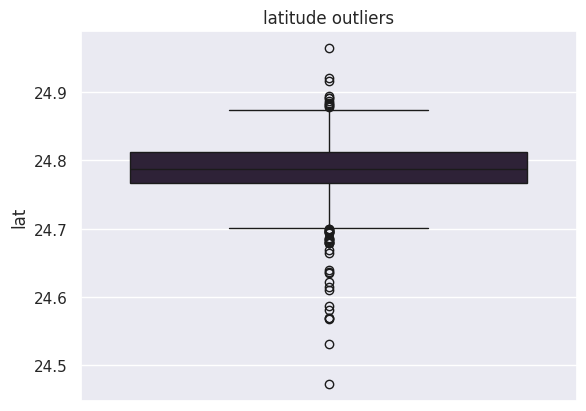

In [ ]:
sns.boxplot(df_no_duplicates['lat'])
plt.title('latitude outliers');

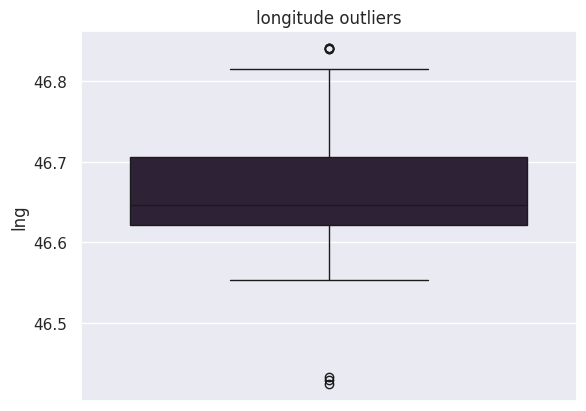

In [ ]:
sns.boxplot(df_no_duplicates['lng'])
plt.title('longitude outliers');

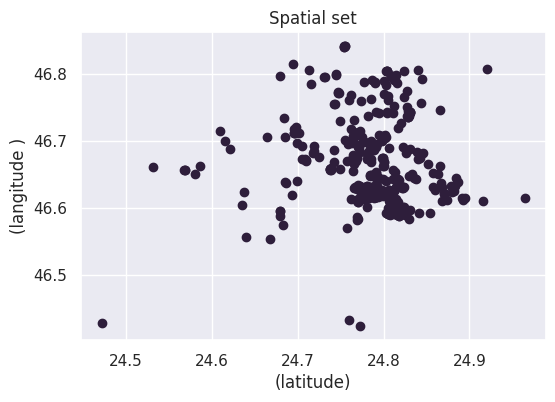

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_no_duplicates['lat'], df_no_duplicates['lng'])
ax.set_xlabel('(latitude)')
ax.set_ylabel('(langitude )')
plt.title('Spatial set')
plt.show()

In [ ]:
X_clustering = df_no_duplicates.iloc[: , 1:3].values

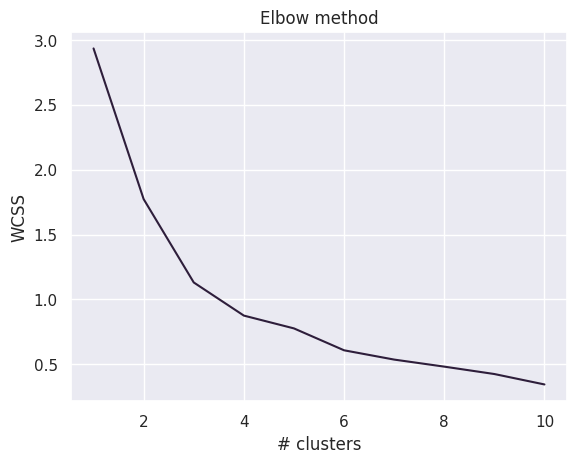

In [ ]:
wcss = []

for cluster in range(1,11):
  kmeans = KMeans(n_clusters = cluster , init = 'k-means++' , random_state = 42)
  kmeans.fit(X_clustering)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,11) , wcss)
plt.title('Elbow method')
plt.xlabel('# clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_clustering)
# 1.6 map data back to df
df_no_duplicates['cluster'] = y_kmeans +1 # to step up to group 1 to 6

In [ ]:
filtered_df = pd.merge(filtered_df,df_no_duplicates[['property_id' , 'cluster']],how='left',on=['property_id'])

In [ ]:
map = folium.Map(location=[df_no_duplicates['lat'].mean(), df_no_duplicates['lng'].mean()],
               tiles='CartoDB positron',
               zoom_start=5)

In [ ]:
layer1 = folium.FeatureGroup(name= '<u><b>cluster 1</b></u>',show= True)
map.add_child(layer1)

layer2 = folium.FeatureGroup(name= '<u><b>cluster 2</b></u>',show= True)
map.add_child(layer2)

layer3 = folium.FeatureGroup(name= '<u><b>cluster 3</b></u>',show= True)
map.add_child(layer3)

layer4 = folium.FeatureGroup(name= '<u><b>cluster 4</b></u>',show= True)
map.add_child(layer4)

layer5 = folium.FeatureGroup(name= '<u><b>cluster 5</b></u>',show= True)
map.add_child(layer5)

layer6 = folium.FeatureGroup(name= '<u><b>cluster 6</b></u>',show= True)
map.add_child(layer6);

In [ ]:
#drawing a marker class for each group by adding CSS class
my_symbol_css_class= """ <style>
.fa-g1:before {
    font-family: Arial;
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px;
    white-space: pre;
    content: ' c1 ';
    }
.fa-g2:before {
    font-family: Arial;
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px;
    white-space: pre;
    content: ' c2 ';
    }
.fa-g3:before {
    font-family: Arial;
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px;
    white-space: pre;
    content: ' c3 ';
    }
.fa-g4:before {
    font-family: Arial;
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px;
    white-space: pre;
    content: ' c4 ';
    }
.fa-g3:before {
    font-family: Arial;
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px;
    white-space: pre;
    content: ' c5 ';
    }
.fa-g4:before {
    font-family: Arial;
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px;
    white-space: pre;
    content: ' c6 ';
    }
</style>
"""

In [ ]:
map.get_root().html.add_child(folium.Element(my_symbol_css_class));

In [ ]:
for index, row in df_no_duplicates.iterrows():
    if row['cluster'] == 1  :
        color='black'
        fa_symbol = 'fa-g1'
        lay = layer1

    elif row['cluster'] == 2 :
        color='purple'
        fa_symbol = 'fa-g2'
        lay = layer2

    elif row['cluster'] == 3 :
        color='orange'
        fa_symbol = 'fa-g3'
        lay = layer3

    elif row['cluster'] == 4 :
        color='blue'
        fa_symbol = 'fa-g4'
        lay = layer4

    elif row['cluster'] == 5 :
        color='green'
        fa_symbol = 'fa-g4'
        lay = layer5

    else:
        color='pink'
        fa_symbol = 'fa-g6'
        lay = layer6

    folium.Marker(
        location=[row['lat'], row['lng']],
        popup = str(row['name'])+ '. cluster:{}'.format(str(row['cluster'])),
        icon= folium.Icon(color=color, icon=fa_symbol, prefix='fa')).add_to(lay)

In [ ]:
layers_list = [layer1,layer2,layer3,layer4,layer5,layer6]
colors_list = ['black','purple','orange','blue','green','pink']

for group in df_no_duplicates['cluster'].unique():

    latlon_cut =df_no_duplicates[df_no_duplicates['cluster']==group].iloc[:, 1:3]

    hull = ConvexHull(latlon_cut.values)
    Lat = latlon_cut.values[hull.vertices,0]
    Long = latlon_cut.values[hull.vertices,1]

    cluster = pd.DataFrame({'lat':Lat,'lng':Long })
    area = list(zip(cluster['lat'],cluster['lng']))

    list_index = group-1 # minus 1 to get the same index
    lay_cluster = layers_list[list_index ]
    folium.Polygon(locations=area,
        color=colors_list[list_index],
        weight=2,
        fill=True,
        fill_opacity=0.1,
        opacity=0.8).add_to(lay_cluster)

# to let the map have selectd layer1 layer2 you created
folium.LayerControl(collapsed=False,position= 'bottomright').add_to(map)

In [ ]:
map.save('clustering_map.html')

In [ ]:
map

#Target variable relations

In [ ]:
filtered_df['price_of_night'] = filtered_df['total'] / filtered_df['stayed_nights'] #target column

In [ ]:
corr_df = filtered_df.select_dtypes(include = 'number').corr()

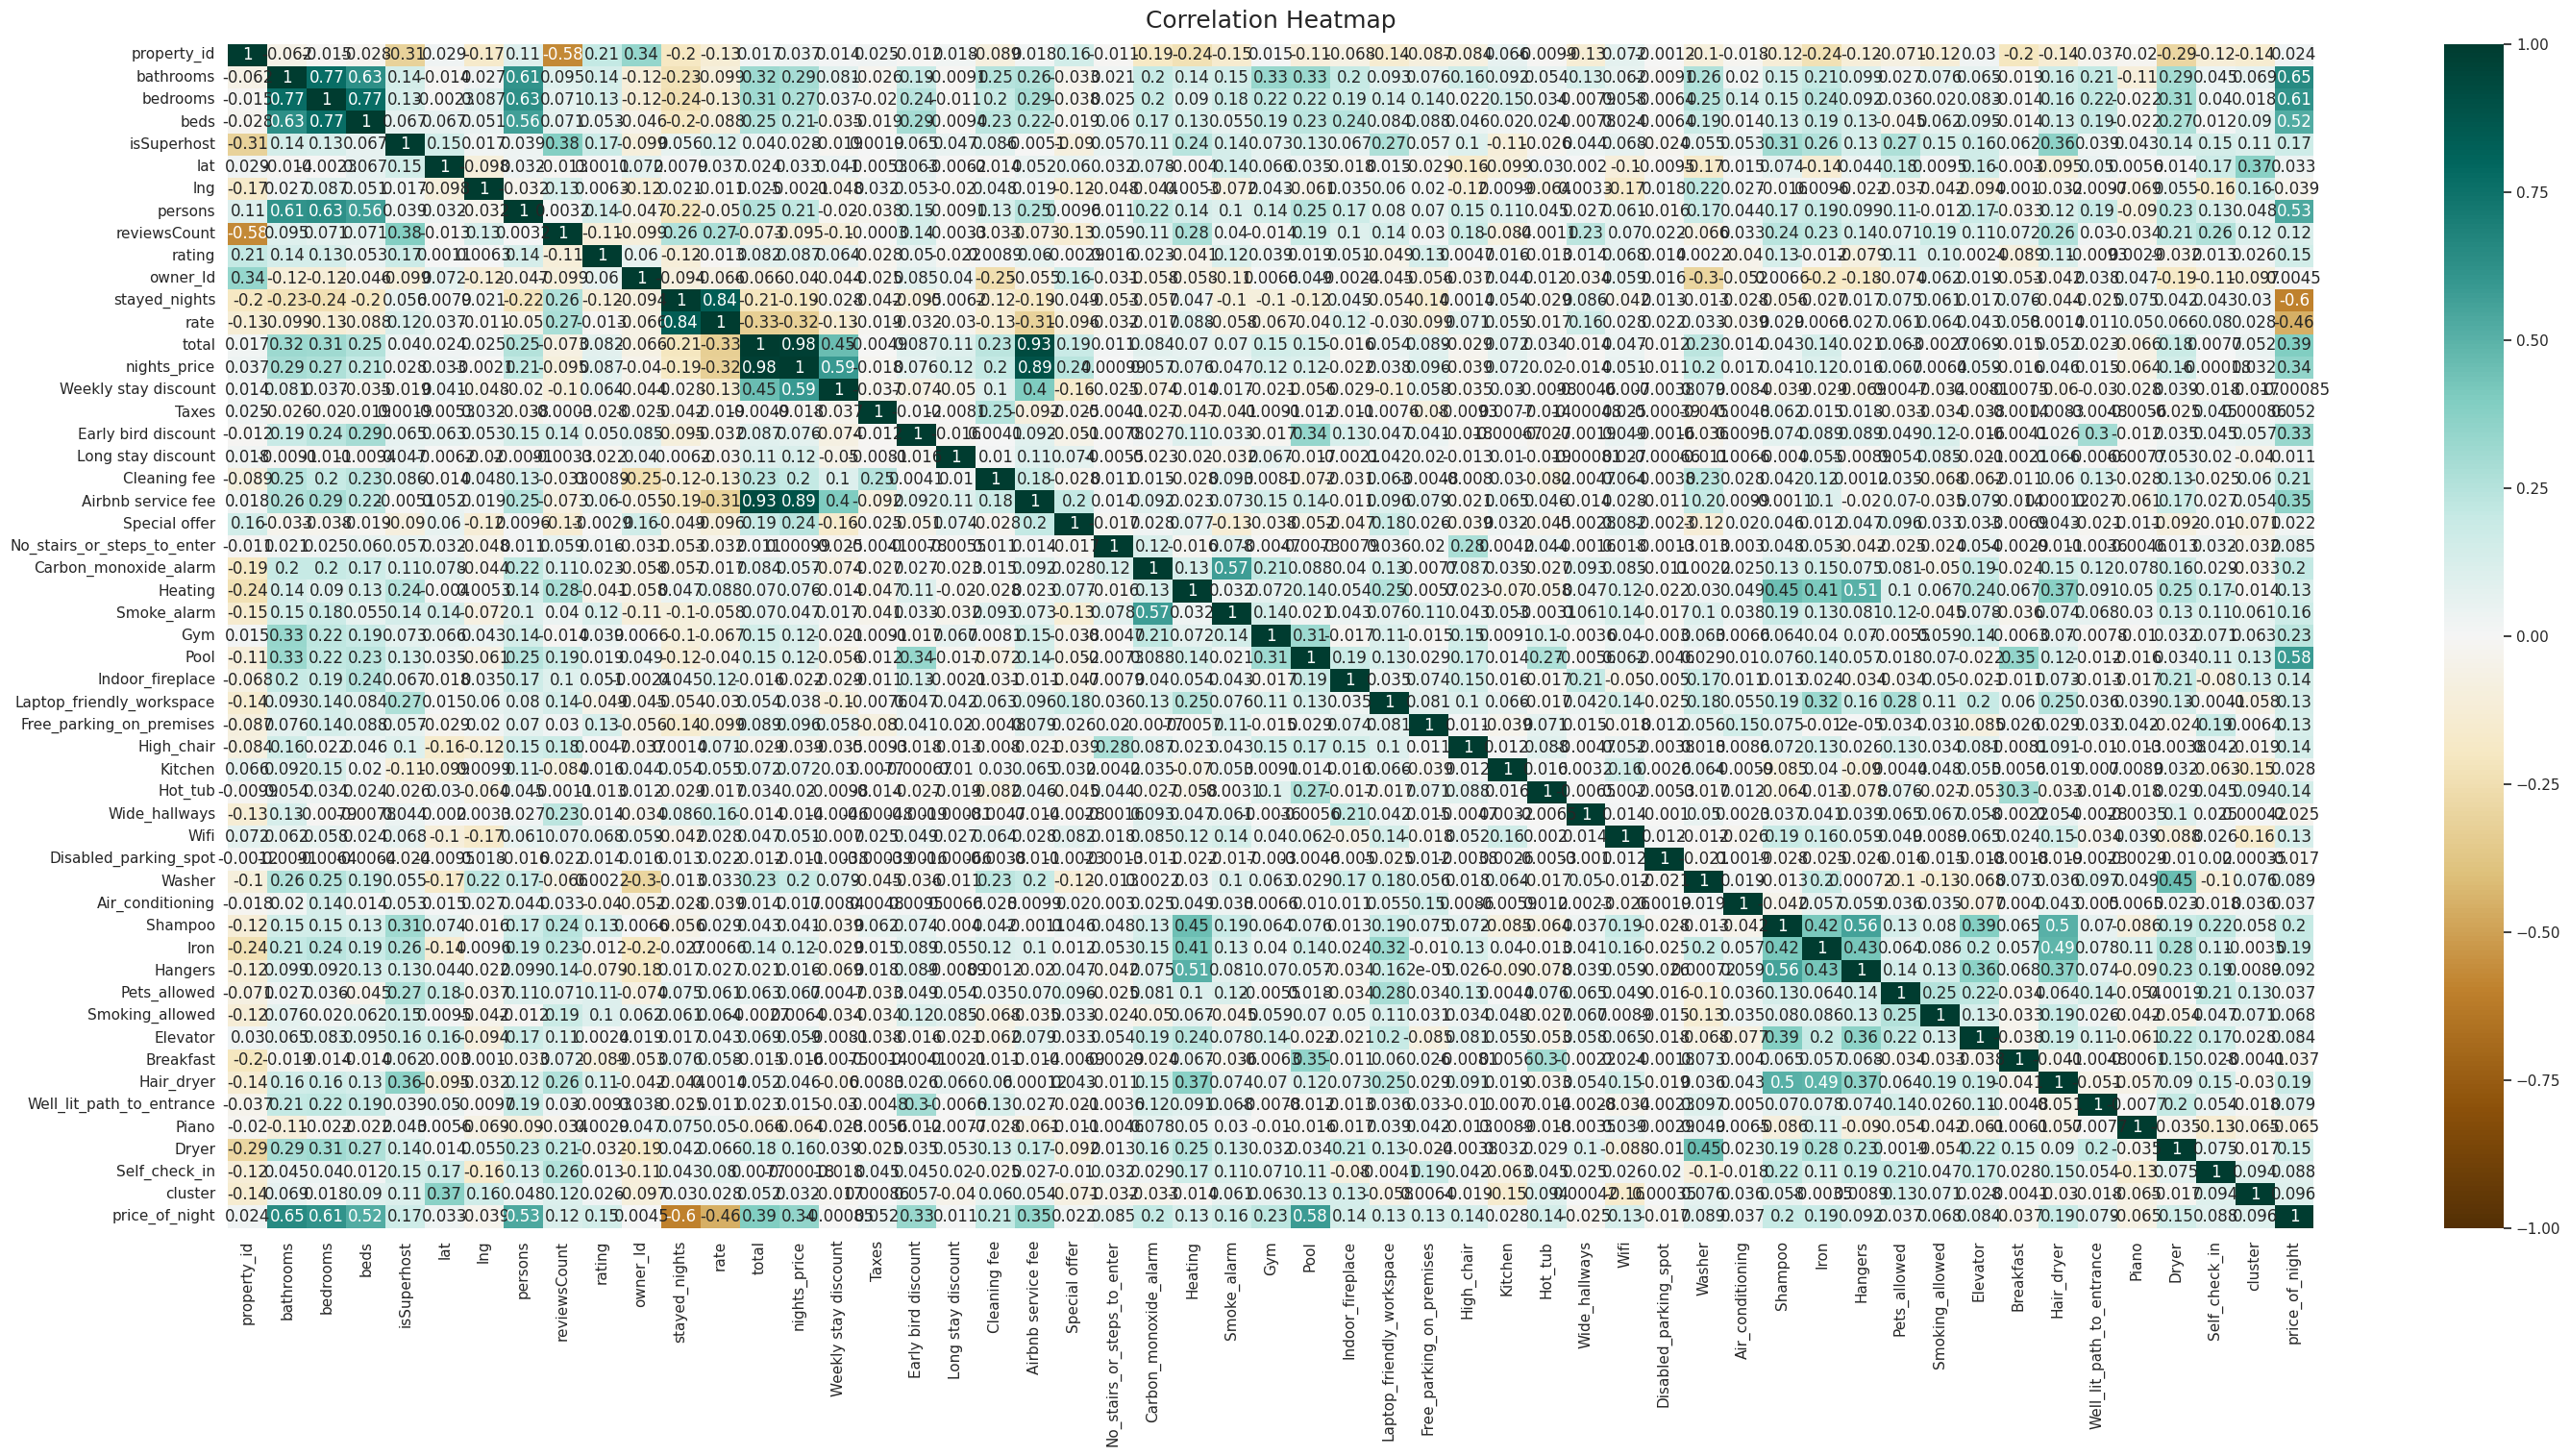

In [ ]:
plt.figure(figsize=(35, 16))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

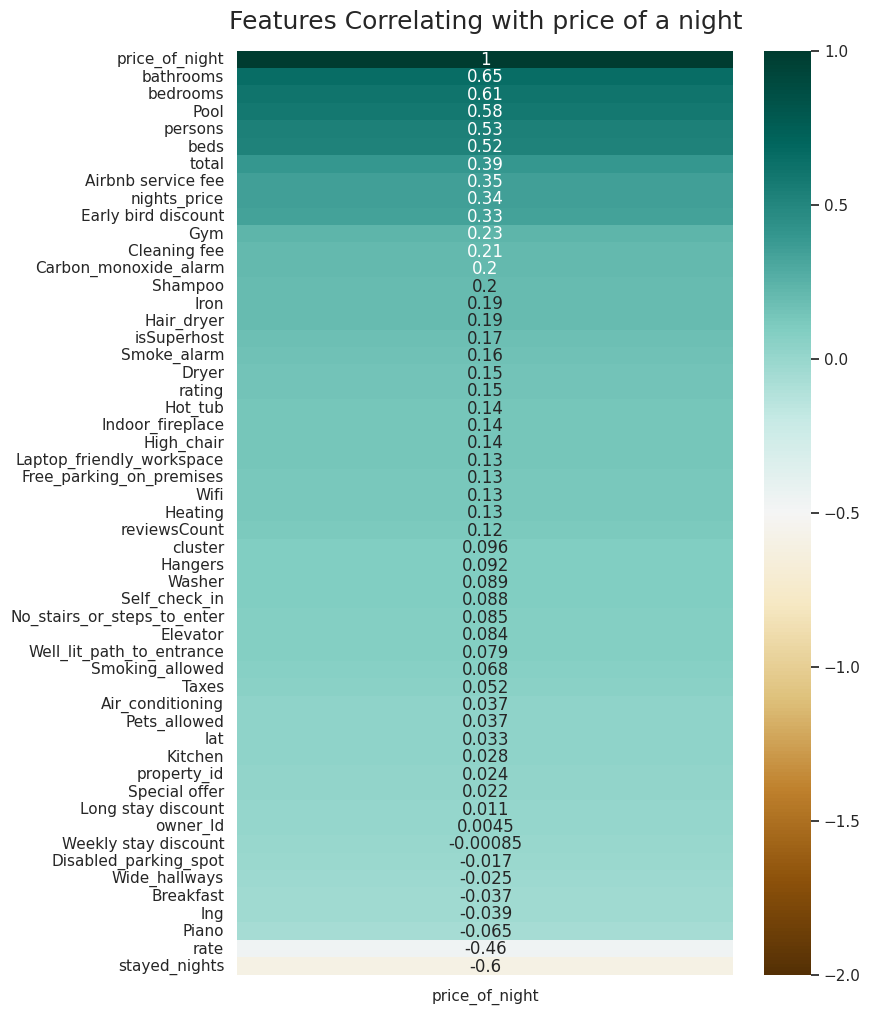

In [ ]:
plt.figure(figsize=(8, 12))
heatmap2 = sns.heatmap(corr_df[['price_of_night']].sort_values(by='price_of_night', ascending=False), vmin=-2, vmax=1, annot=True, cmap='BrBG')
heatmap2.set_title('Features Correlating with price of a night', fontdict={'fontsize':18}, pad=16);

In [ ]:
#splitting dataset
X = filtered_df[['governorates',
                  'cluster',  'persons' , 'bathrooms',
                  'reviewsCount', 'Wifi' , 'Gym',
                  'stayed_nights','cancelPolicy' , 'Breakfast' ,'Wide_hallways' ,
                   ]].copy()
y =filtered_df[['price_of_night']].copy()

#Data distribution

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)


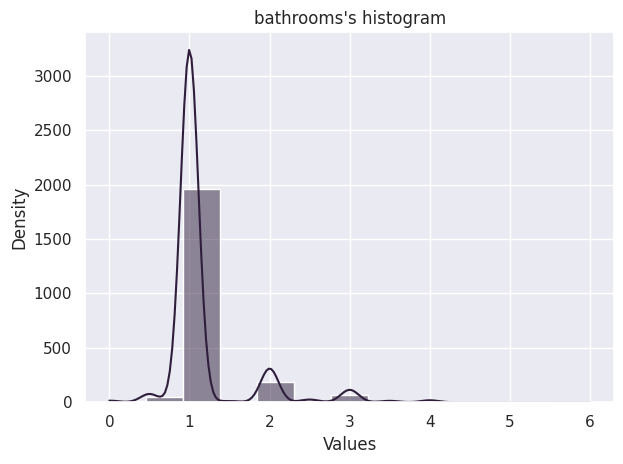

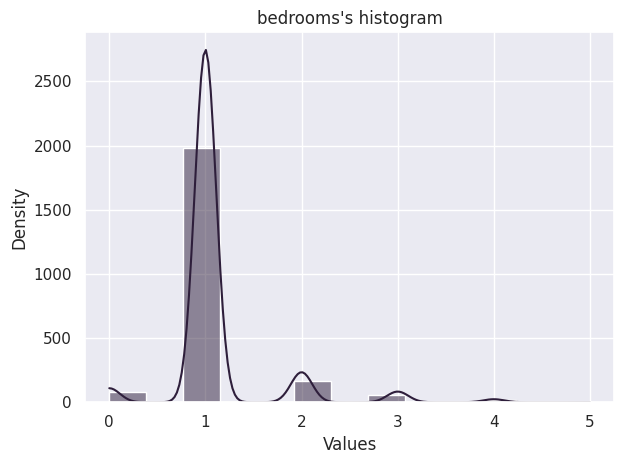

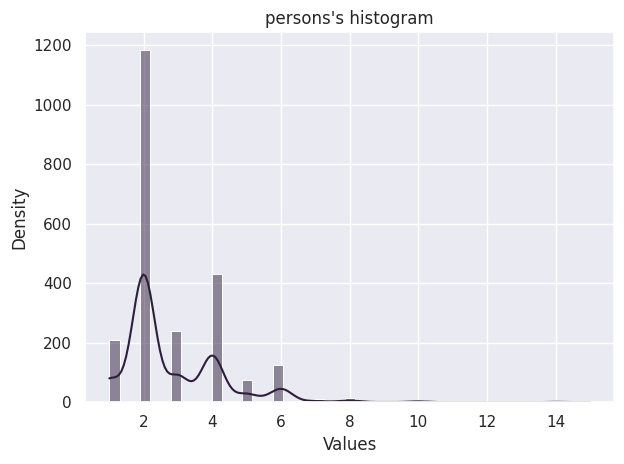

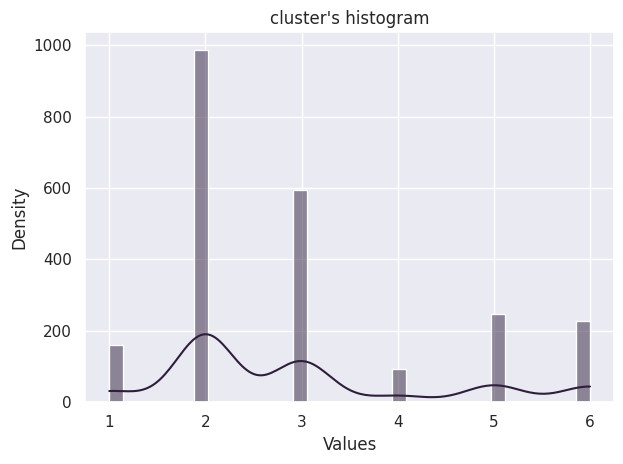

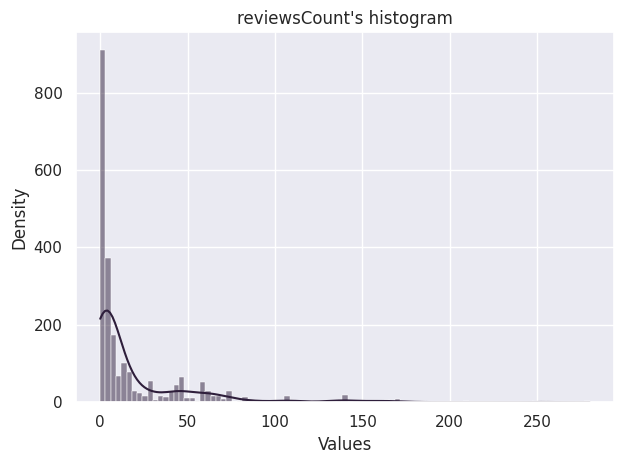

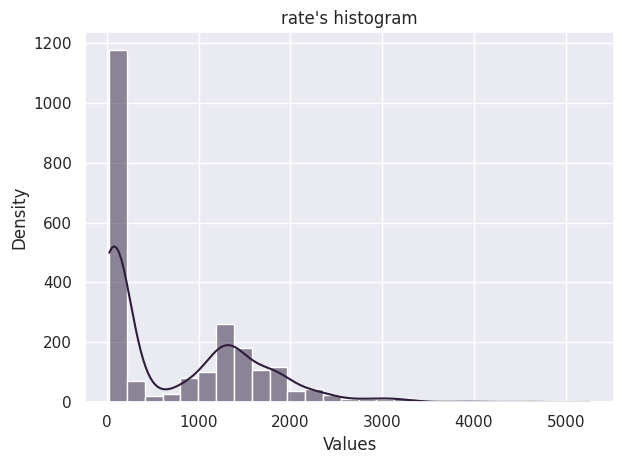

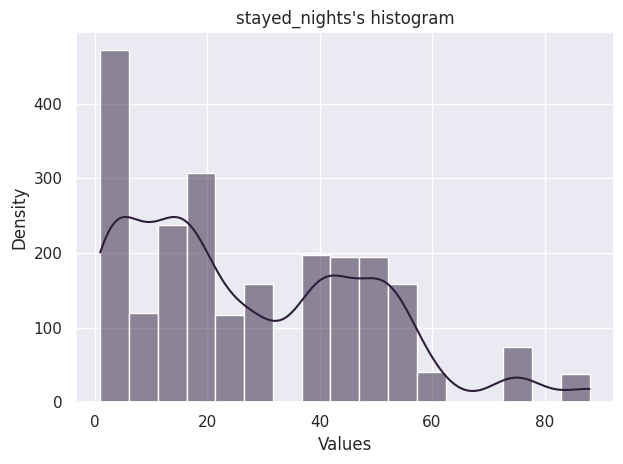

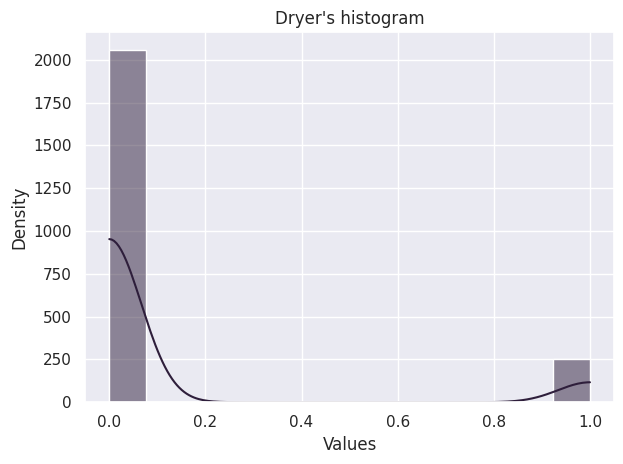

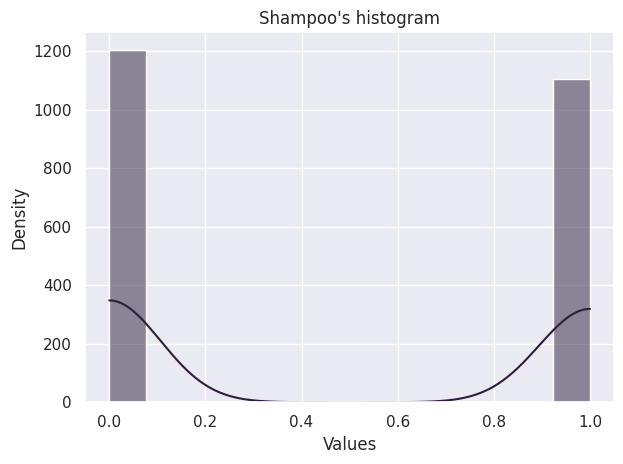

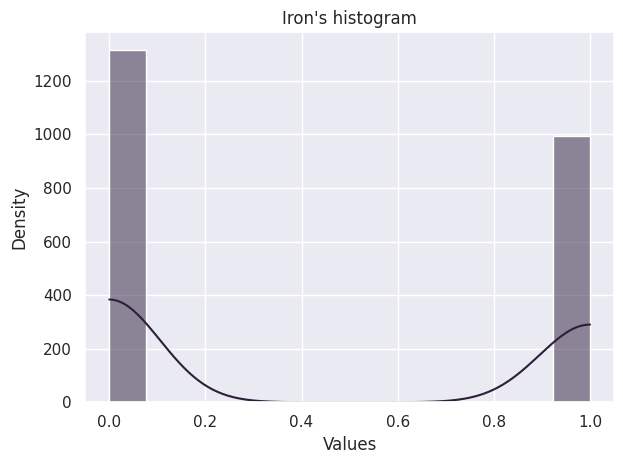

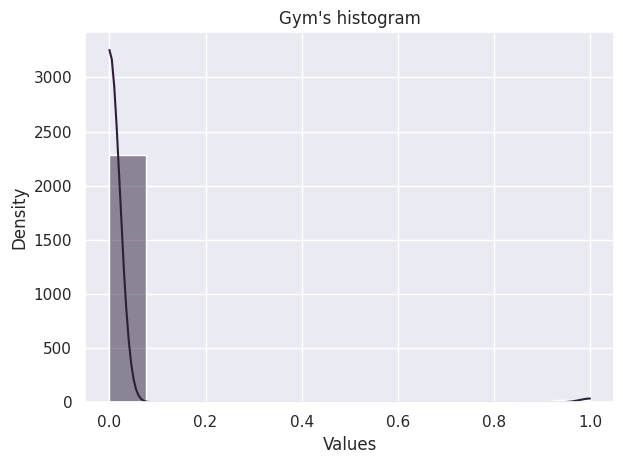

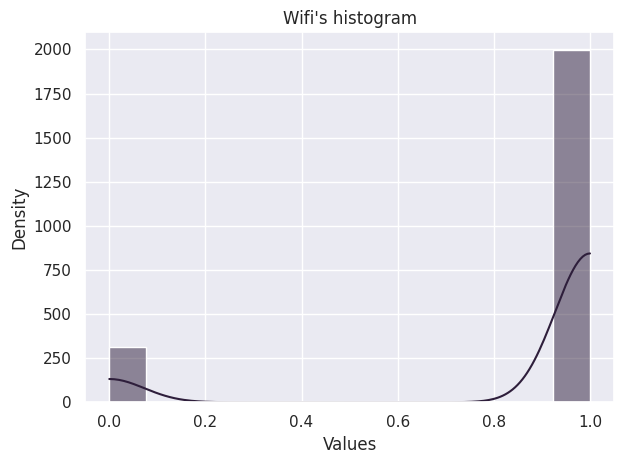

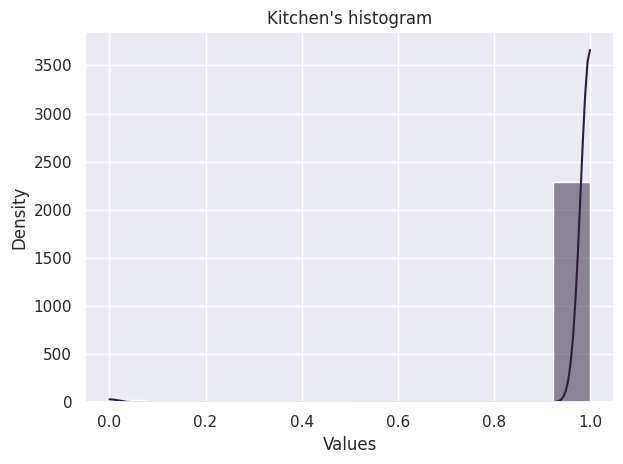

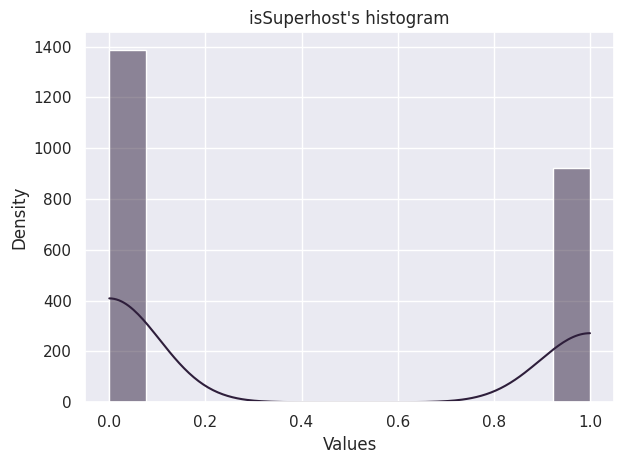

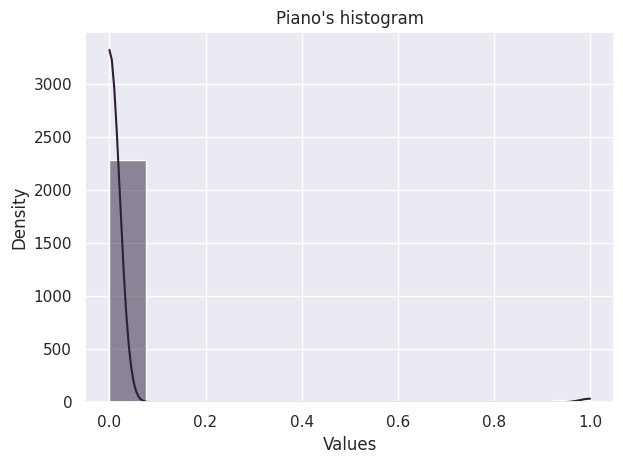

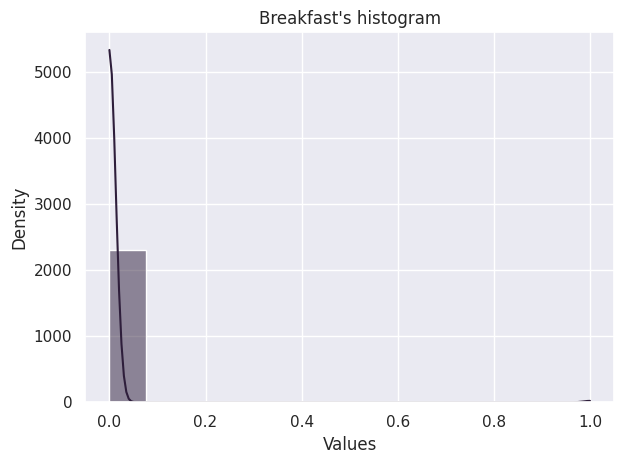

In [ ]:
hist_cols = X_train.select_dtypes(include = 'number').columns.to_list()

for column in hist_cols:
  histograms(X_train[f"{column}"])

#Data Prepration

In [ ]:
cat_cols = X.select_dtypes(include = 'object').columns.to_list()
num_cols = X.select_dtypes(include = 'number').columns.to_list()



cat_pipe = make_pipeline(OneHotEncoder())
trans_pipe = make_pipeline(StandardScaler())

preprocessing_pipe = ColumnTransformer(
    [
        ("numerical" , trans_pipe , num_cols) ,
        ("categorical" , cat_pipe , cat_cols)
    ]
)


In [ ]:
X_train_preprocessed = preprocessing_pipe.fit_transform(X_train)
X_val_preprocessed = preprocessing_pipe.transform(X_val)
X_test_preprocessed = preprocessing_pipe.transform(X_test)

#Model training and results

In [ ]:
dt = DecisionTreeRegressor(
      max_depth = 35 ,
      min_samples_leaf = 2 , random_state =42
)

dt.fit(X_train_preprocessed,y_train)

y_predicted_dt = dt.predict(X_val_preprocessed)

print(f"Mean absolute error score val set dt: {mean_absolute_error(y_val , y_predicted_dt):.3f}")
print(f"Mean squared error score val set dt: {mean_squared_error(y_val , y_predicted_dt):.3f}")
print(f"R2  score val set dt: {r2_score(y_val , y_predicted_dt):.3f}")
print(f"Root mean squared  score val set dt: {root_mean_squared_error(y_val , y_predicted_dt):.3f}") #just use standard scaler then

Mean absolute error score val set dt: 2.812
Mean squared error score val set dt: 54.159
R2  score val set dt: 0.984
Root mean squared  score val set dt: 7.359


In [ ]:
ada_reg = AdaBoostRegressor(
    dt , n_estimators = 600 ,
    learning_rate = .01 ,
)

ada_reg.fit(X_train_preprocessed , y_train)


y_predicted_ada = ada_reg.predict(X_val_preprocessed)

MAE_VAL = mean_absolute_error(y_val , y_predicted_ada)
MSE_VAL = mean_squared_error(y_val , y_predicted_ada)
R2_VAL = r2_score(y_val , y_predicted_ada)
RMSE_VAL = root_mean_squared_error(y_val , y_predicted_ada)
MEDAE_VAL = median_absolute_error(y_val , y_predicted_ada)
medse = MedianSquaredError()
MEDSE_VAL = medse(np.array(y_val).reshape(1,234)[0] , y_predicted_ada.reshape(1,234)[0])

print(f"Mean absolute error score val set adaboost: {MAE_VAL:.3f}")
print(f"Mean squared error score val set adaboost: {MSE_VAL:.3f}")
print(f"R2  score val set adaboost: {R2_VAL:.3f}")
print(f"Root mean squared  score val set adaboost: {RMSE_VAL:.3f}")
print(f"median absolute error val set adaboost: {MEDAE_VAL:.3f}")

print(f"median squared error test val adaboost: {MEDSE_VAL:.9f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Mean absolute error score val set adaboost: 2.302
Mean squared error score val set adaboost: 48.813
R2  score val set adaboost: 0.985
Root mean squared  score val set adaboost: 6.987
median absolute error val set adaboost: 0.139
median squared error test val adaboost: 0.019320988


In [ ]:
y_predicted_ada_test = ada_reg.predict(X_test_preprocessed)

MAE_TEST = mean_absolute_error(y_test , y_predicted_ada_test)
MSE_TEST= mean_squared_error(y_test , y_predicted_ada_test)
R2_TEST = r2_score(y_test , y_predicted_ada_test)
RMSE_TEST = root_mean_squared_error(y_test , y_predicted_ada_test)
MEDAE_TEST = median_absolute_error(y_test , y_predicted_ada_test)
MEDSE_TEST = medse(np.array(y_test).reshape(1,24)[0] , y_predicted_ada_test.reshape(1,24)[0])

print(f"Mean absolute error score test set adaboost: {MAE_TEST:.3f}")
print(f"Mean squared error score test set adaboost: {MSE_TEST:.3f}")
print(f"R2  score test set adaboost: {R2_TEST:.3f}")
print(f"Root mean squared  score test set adaboost: {RMSE_TEST:.3f}")
print(f"median absolute error test set adaboost: {MEDAE_TEST:.3f}")
print(f"median squared error test set adaboost: {MEDSE_TEST:.3f}")

Mean absolute error score test set adaboost: 1.816
Mean squared error score test set adaboost: 13.894
R2  score test set adaboost: 0.995
Root mean squared  score test set adaboost: 3.727
median absolute error test set adaboost: 0.128
median squared error test set adaboost: 0.017


In [ ]:
val_test = {


    'score_r2' : [R2_VAL,R2_TEST] ,
    'score_mae' : [MAE_VAL , MAE_TEST] ,
    "data" : ["validation" , "test"]
}
scores = pd.DataFrame(val_test)
scores

score_r2  score_mae        data
0      0.99       2.30  validation
1      1.00       1.82        test

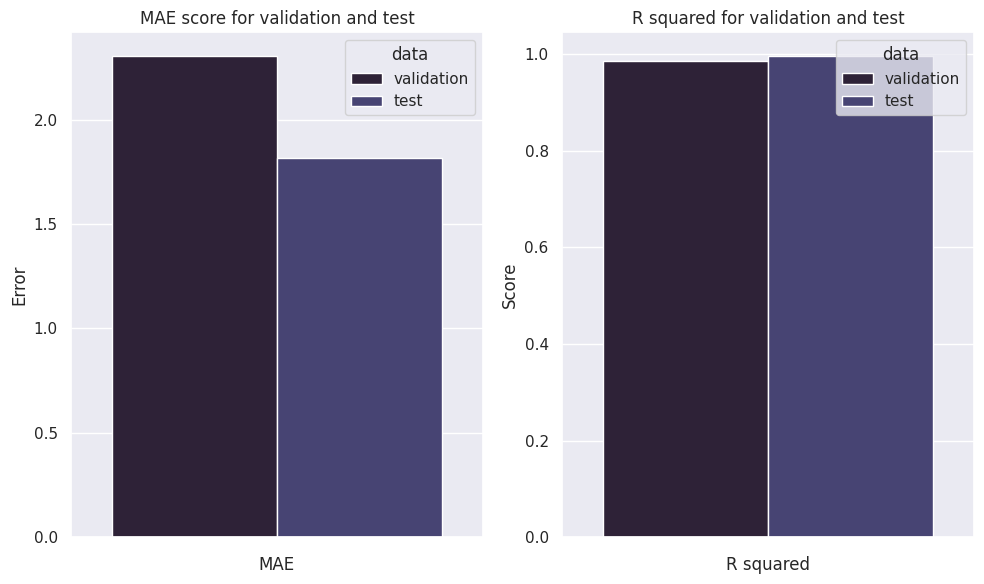

In [ ]:
fig , axes = plt.subplots(1, 2, figsize=(10, 6))

#MSE
sns.barplot(data=val_test ,y='score_mae',hue='data' ,  ax=axes[0] )
axes[0].set_title('MAE score for validation and test')
axes[0].set_xlabel('MAE')
axes[0].set_ylabel('Error')


#R sqared
sns.barplot(data=val_test, y='score_r2',hue='data', ax=axes[1])
axes[1].set_title('R squared for validation and test')
axes[1].set_xlabel('R squared')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [ ]:
pipeline = {'clustering' : kmeans , 'regression' : ada_reg , 'transformation' : preprocessing_pipe}
with open('pipeline_train.pkl','wb') as file:
  pickle.dump(pipeline,file)